<a href="https://colab.research.google.com/github/kkostromin/sber_ds/blob/main/age_and_gender_detection_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install utils

In [ ]:
!pip install ipython-autotime
!pip install tqdm

%load_ext autotime


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 524 µs (started: 2022-12-26 12:37:47 +00:00)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlb
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tqdm import tqdm

time: 1.69 ms (started: 2022-12-26 14:24:01 +00:00)


Kaggle connect

In [ ]:
! pip install -q kaggle

time: 4.35 s (started: 2022-12-26 12:38:00 +00:00)


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists
time: 125 ms (started: 2022-12-26 12:39:00 +00:00)


In [ ]:
! cp kaggle.json ~/.kaggle/

time: 121 ms (started: 2022-12-26 12:39:02 +00:00)


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

time: 126 ms (started: 2022-12-26 12:39:03 +00:00)


In [ ]:
! kaggle datasets list

ref                                                             title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                 5MB  2022-11-13 15:47:17          12958        372  1.0              
thedevastator/analyzing-credit-card-spending-habits-in-india    Credit Card Spending Habits in India           319KB  2022-12-14 07:30:37            670         29  1.0              
michals22/coffee-dataset                                        Coffee dataset                                  24KB  2022-12-15 20:02:12           2738         70  1.0              
thedevastator/unlock-profits-with-e-commerce-sales-data         E-Commerce Sales Data

In [ ]:
! kaggle datasets download -d jangedoo/utkface-new

100% 331M/331M [00:02<00:00, 189MB/s]
100% 331M/331M [00:02<00:00, 137MB/s]
time: 3.26 s (started: 2022-12-26 12:39:09 +00:00)


In [ ]:
! mkdir utkface-new

mkdir: cannot create directory ‘utkface-new’: File exists
time: 134 ms (started: 2022-12-26 12:39:16 +00:00)


In [ ]:
! unzip utkface-new.zip -d utkface-new

Streaming output truncated to the last 5000 lines.
  inflating: utkface-new/utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface-new/utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface-new/utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface-new/utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface-new/utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface-new/utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface-new/utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface-new/utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface-new/utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface-new/utkface_aligned_cropped/

# 1.Data preprocessing

In [ ]:
# Kaggle download
path_kaggel = "/kaggle/input/utkface-new/UTKFace/"

# Colab download
path_colab = "utkface-new/UTKFace/"

files = os.listdir(path_colab)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
30_1_0_20170117131108776.jpg.chip.jpg
time: 17.7 ms (started: 2022-12-26 12:39:56 +00:00)


Data I have downloaded is composed of 23,708 images with age and gender in the Image Name. For Example, 1_0_0_239389.JPG image means that age is 1, gender is 0 (male) and 0 refers to the race (not needed in this task).
So I split the image name on ' _ ' so I can get separated age and gender with image.
Also, I have shuffle all the images

In [ ]:
import cv2

age_labels, gender_labels, image_path = [], [], []

for file in  tqdm(files):
    image = cv2.imread(path_colab + file,0)
    image = cv2.resize(image,dsize=(64,64))
    image = image.reshape((image.shape[0],image.shape[1],1))
    image_path.append(image)
    split_var = file.split('_')
    age_labels.append(split_var[0])
    gender_labels.append(int(split_var[1]) )

100%|██████████| 23708/23708 [00:05<00:00, 4047.48it/s]

time: 6.29 s (started: 2022-12-26 12:40:01 +00:00)


In [ ]:
image_path[0].shape

(64, 64, 1)

time: 4.35 ms (started: 2022-12-26 11:52:56 +00:00)


# 2. From Unstructured data to Structured data

In [ ]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels

time: 32.3 ms (started: 2022-12-26 12:40:15 +00:00)


In [ ]:
df.head()

image age  gender
0  [[[70], [63], [50], [57], [80], [91], [93], [1...  30       1
1  [[[89], [85], [83], [83], [83], [82], [82], [8...  26       1
2  [[[29], [60], [21], [5], [17], [24], [36], [45...  28       1
3  [[[95], [93], [91], [90], [91], [92], [104], [...  35       1
4  [[[83], [82], [71], [63], [54], [52], [47], [3...  34       1

time: 3.43 s (started: 2022-12-26 12:40:15 +00:00)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   23708 non-null  object
 1   age     23708 non-null  object
 2   gender  23708 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 555.8+ KB
time: 23.1 ms (started: 2022-12-26 12:40:19 +00:00)


In [ ]:
gender_dict = {0:"Male",1:"Female"}
df = df.astype({'age':'float32', 'gender': 'int32'})
print(df.dtypes)

image      object
age       float32
gender      int32
dtype: object
time: 11.7 ms (started: 2022-12-26 12:40:19 +00:00)


In [ ]:
df.describe()

age        gender
count  23708.000000  23708.000000
mean      33.303486      0.477349
std       19.886112      0.499497
min        1.000000      0.000000
25%       23.000000      0.000000
50%       29.000000      0.000000
75%       45.000000      1.000000
max      116.000000      1.000000

time: 20.9 ms (started: 2022-12-26 12:40:19 +00:00)


Gender: 1 Age: 31


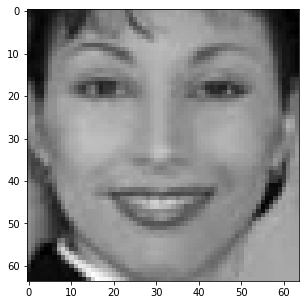

time: 139 ms (started: 2022-12-26 12:40:19 +00:00)


In [ ]:
def display(img):
    plt.figure(figsize=(5,5))
    # plt.imshow(img[:,:,0])
    plt.imshow(img[:,:,0], cmap='gray')

    # plt.imshow(img)
    # plt.set_cmap('gray')
    plt.show()
idx = 900
sample = image_path[idx]
print("Gender:",gender_labels[idx],"Age:",age_labels[idx])
display(sample)

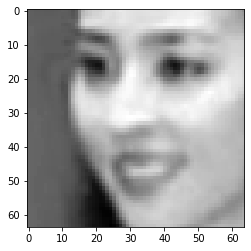

time: 139 ms (started: 2022-12-26 12:40:19 +00:00)


In [ ]:
plt.imshow(df['image'][1][:,:,0], cmap='gray')

In [ ]:
df['image'][1].shape

(64, 64, 1)

time: 4.56 ms (started: 2022-12-26 12:40:19 +00:00)


# 3. Plotting Images

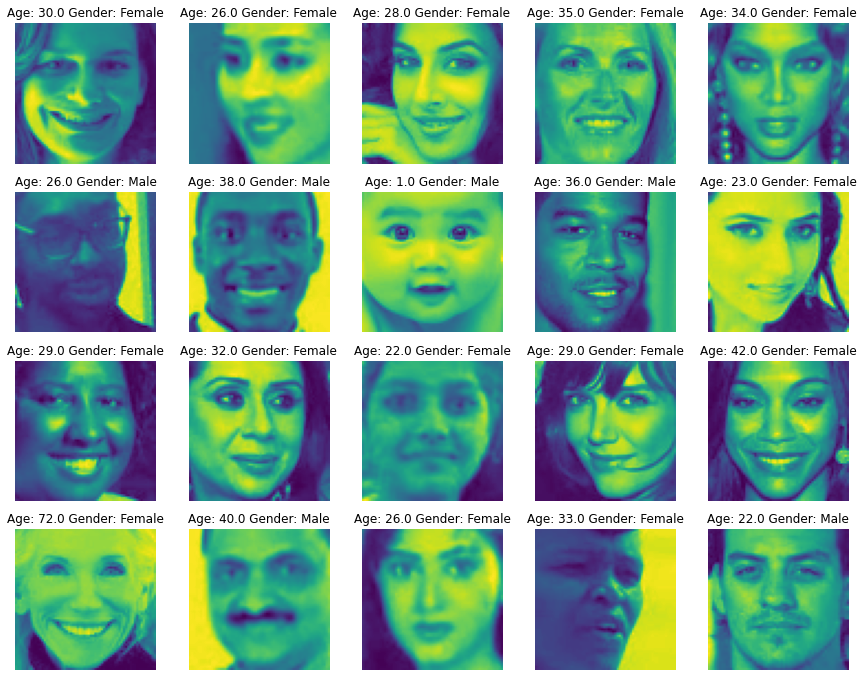

time: 915 ms (started: 2022-12-26 12:40:21 +00:00)


In [ ]:
files = df.iloc[0:20]
plt.figure(figsize=(15,15))
for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = np.array(df['image'][index])
    plt.imshow(img[:,:,0])
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

# 4. Visualising and Preparing Data

In [ ]:
df2 = df.copy()

time: 1.36 ms (started: 2022-12-26 12:40:27 +00:00)


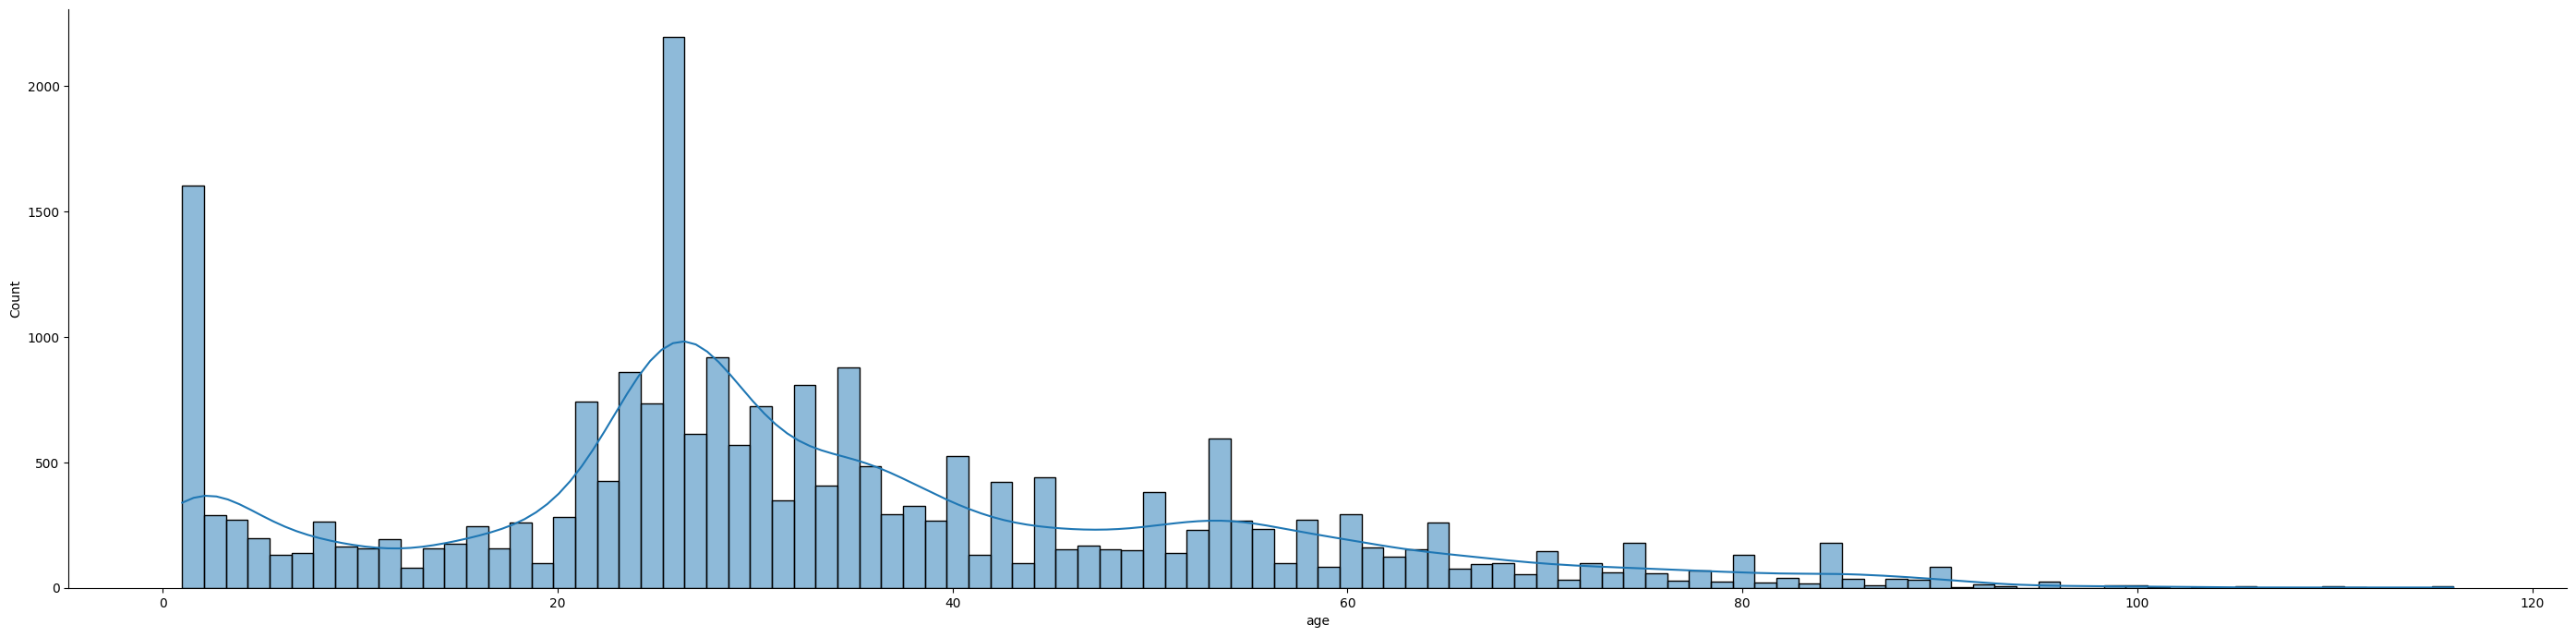

time: 773 ms (started: 2022-12-26 12:40:27 +00:00)


In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
ax = sns.displot(data=df2['age'], kde=True, height=7, aspect=4,  bins = 104)
ax.fig.set_dpi(100)

In [ ]:
df2.shape

(23708, 3)

time: 3.45 ms (started: 2022-12-26 12:40:28 +00:00)


time: 12.9 ms (started: 2022-12-26 12:40:28 +00:00)


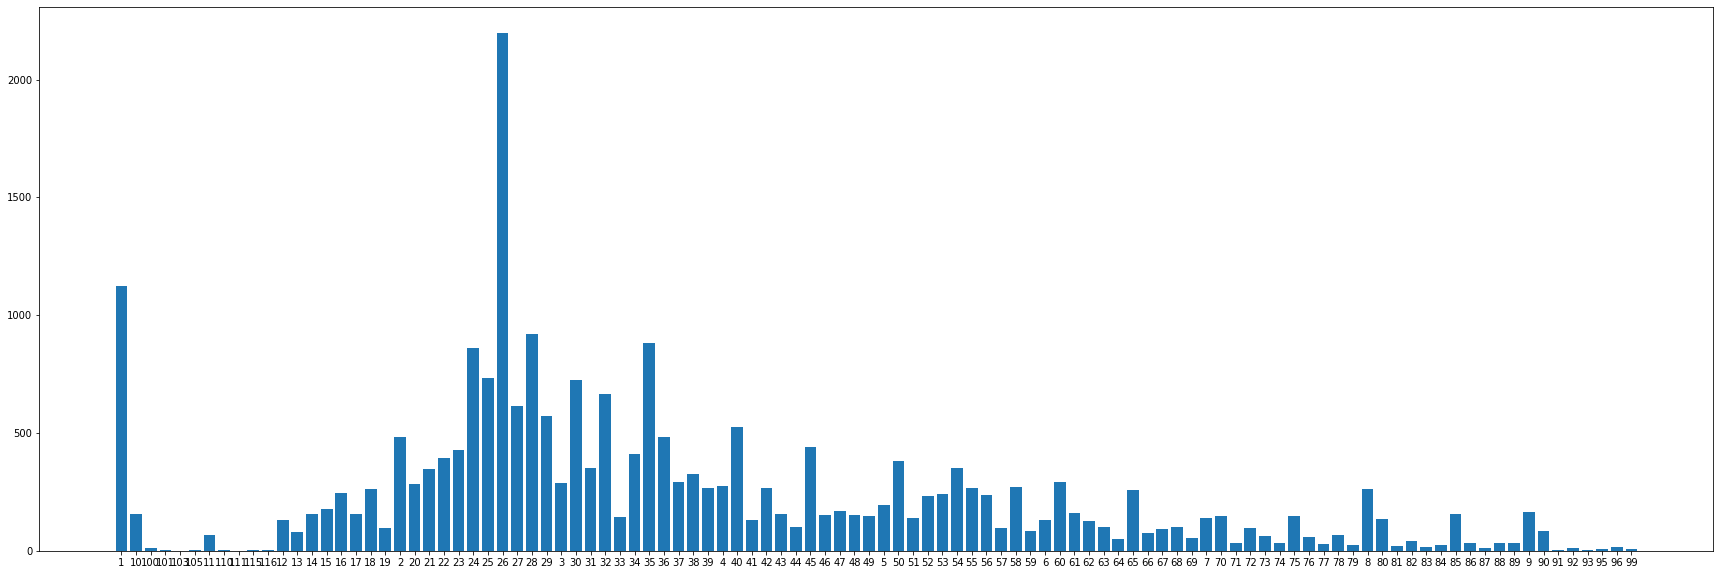

Max value: 99
time: 1.02 s (started: 2022-12-26 12:40:28 +00:00)


In [ ]:
plt.rcParams["figure.figsize"] = (30,10)
plt.rc('font', size = 10)
x_ages = sorted(list(set(age_labels)))

y_ages = [age_labels.count(i) for i in x_ages]

plt.bar(x_ages,y_ages)
plt.show()

print("Max value:",max(age_labels))

In [ ]:
len(df2[df2['age'] == 1.0].index)

1123

time: 5.42 ms (started: 2022-12-26 12:40:29 +00:00)


In [ ]:
# уберем избыточные данну для возраста 1 год

down2s = []

for i in range(len(df2)):
    if df2['age'].iloc[i] == 1.0:
        down2s.append(df2.iloc[i])
down2s = pd.DataFrame(down2s)
down2s = down2s.sample(frac=0.3)

df2 = df2[df2['age'] > 1]

df2 = pd.concat([df2, down2s], ignore_index = False)

time: 364 ms (started: 2022-12-26 12:40:29 +00:00)


In [ ]:
len(df2[df2['age'] == 1.0].index)

337

time: 5.21 ms (started: 2022-12-26 12:40:29 +00:00)


In [ ]:
df2.shape

(22922, 3)

time: 7.78 ms (started: 2022-12-26 12:40:29 +00:00)


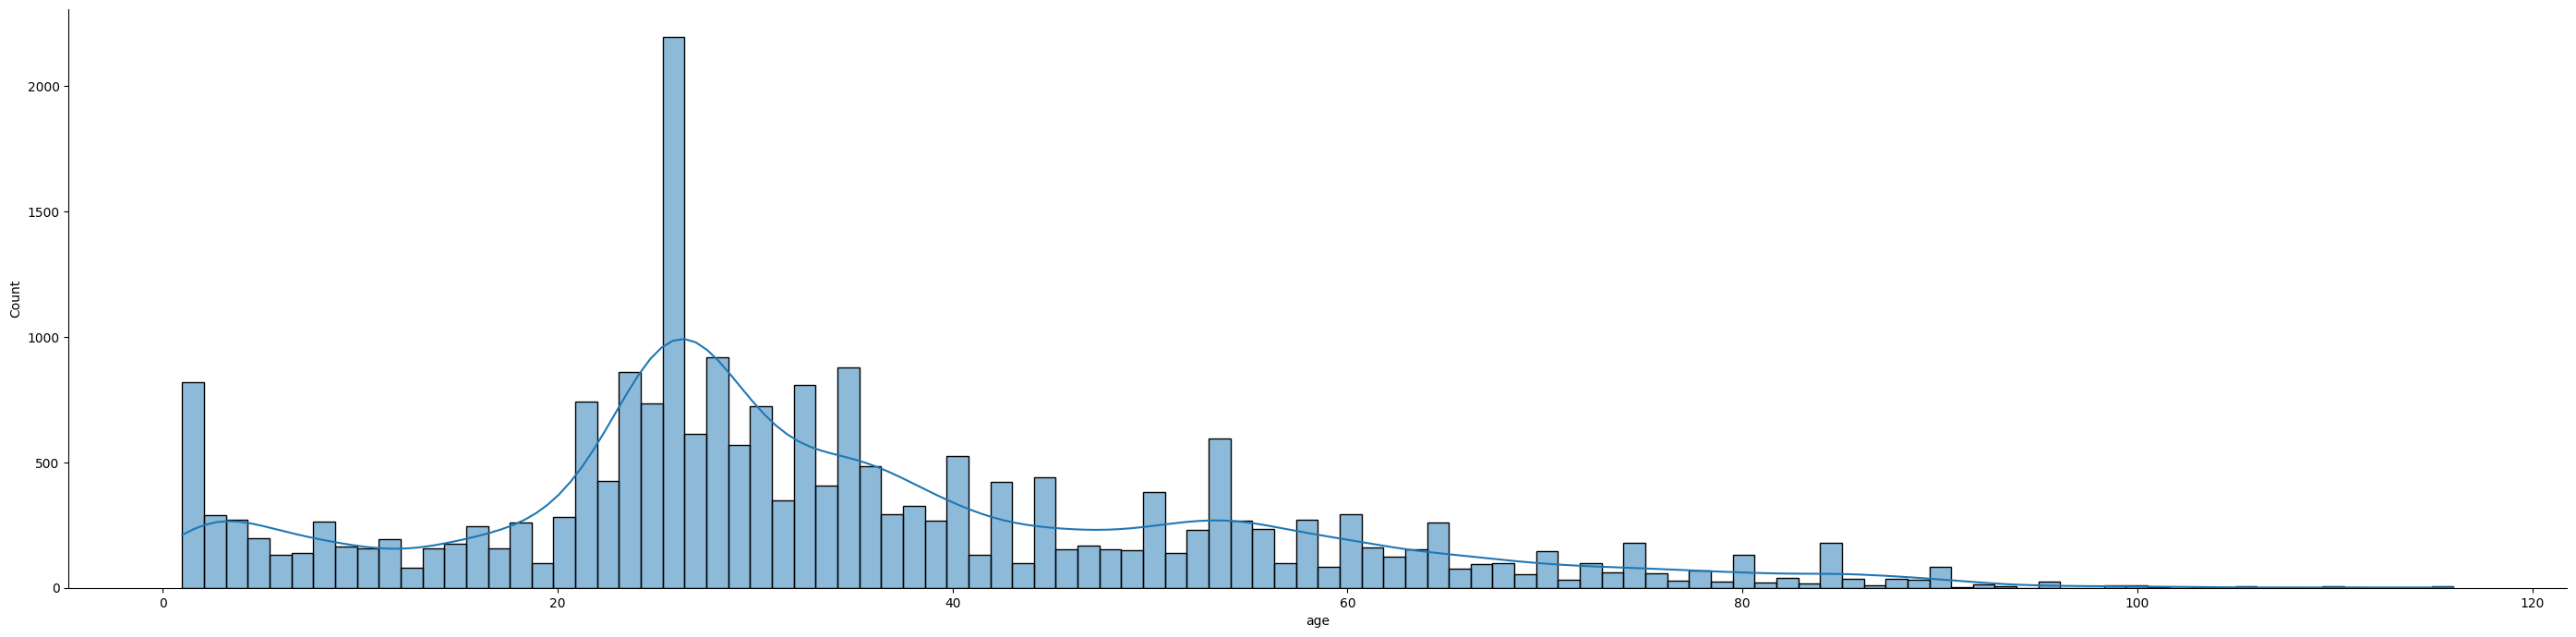

time: 745 ms (started: 2022-12-26 12:40:29 +00:00)


In [ ]:
# sns.distplot(df2['age'],kde=True, bins=120.
ax = sns.displot(data=df2['age'], kde=True, height=7, aspect=4,  bins = 104)
ax.fig.set_dpi(100)

In [ ]:
# уберем избыточные данну для возраста 26 лет
age_list = []

for i in range(len(df2)):
    if (df2['age'].iloc[i] == 26): 
        age_list.append(df2.iloc[i])
age_list = pd.DataFrame(age_list)
age_list = age_list.sample(frac=0.3)

df2 = df2.loc[df2['age'] != 26]

df2 = pd.concat([df2, age_list], ignore_index = False)

time: 477 ms (started: 2022-12-26 12:40:30 +00:00)


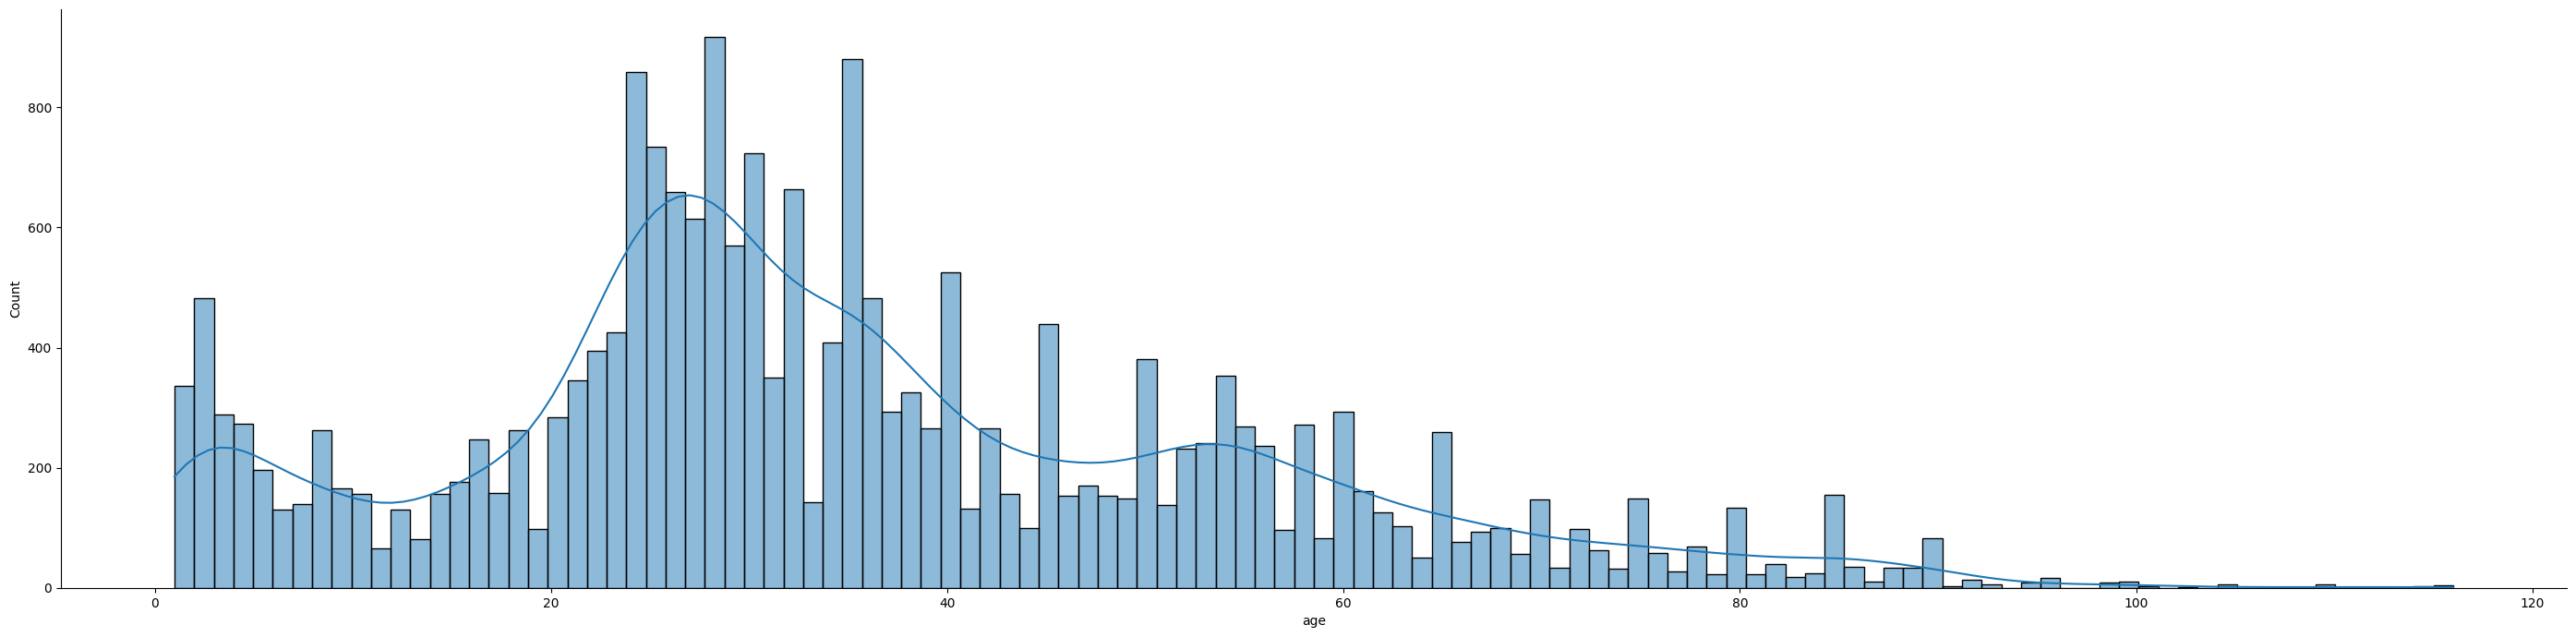

time: 782 ms (started: 2022-12-26 12:40:31 +00:00)


In [ ]:
# sns.distplot(df2['age'],kde=True, bins=120)
ax = sns.displot(data=df2['age'], kde=True, height=7, aspect=4,  bins = 116)
ax.fig.set_dpi(100)

In [ ]:
df2 = df2[df2['age'] < 90]

time: 4.34 ms (started: 2022-12-26 12:40:31 +00:00)


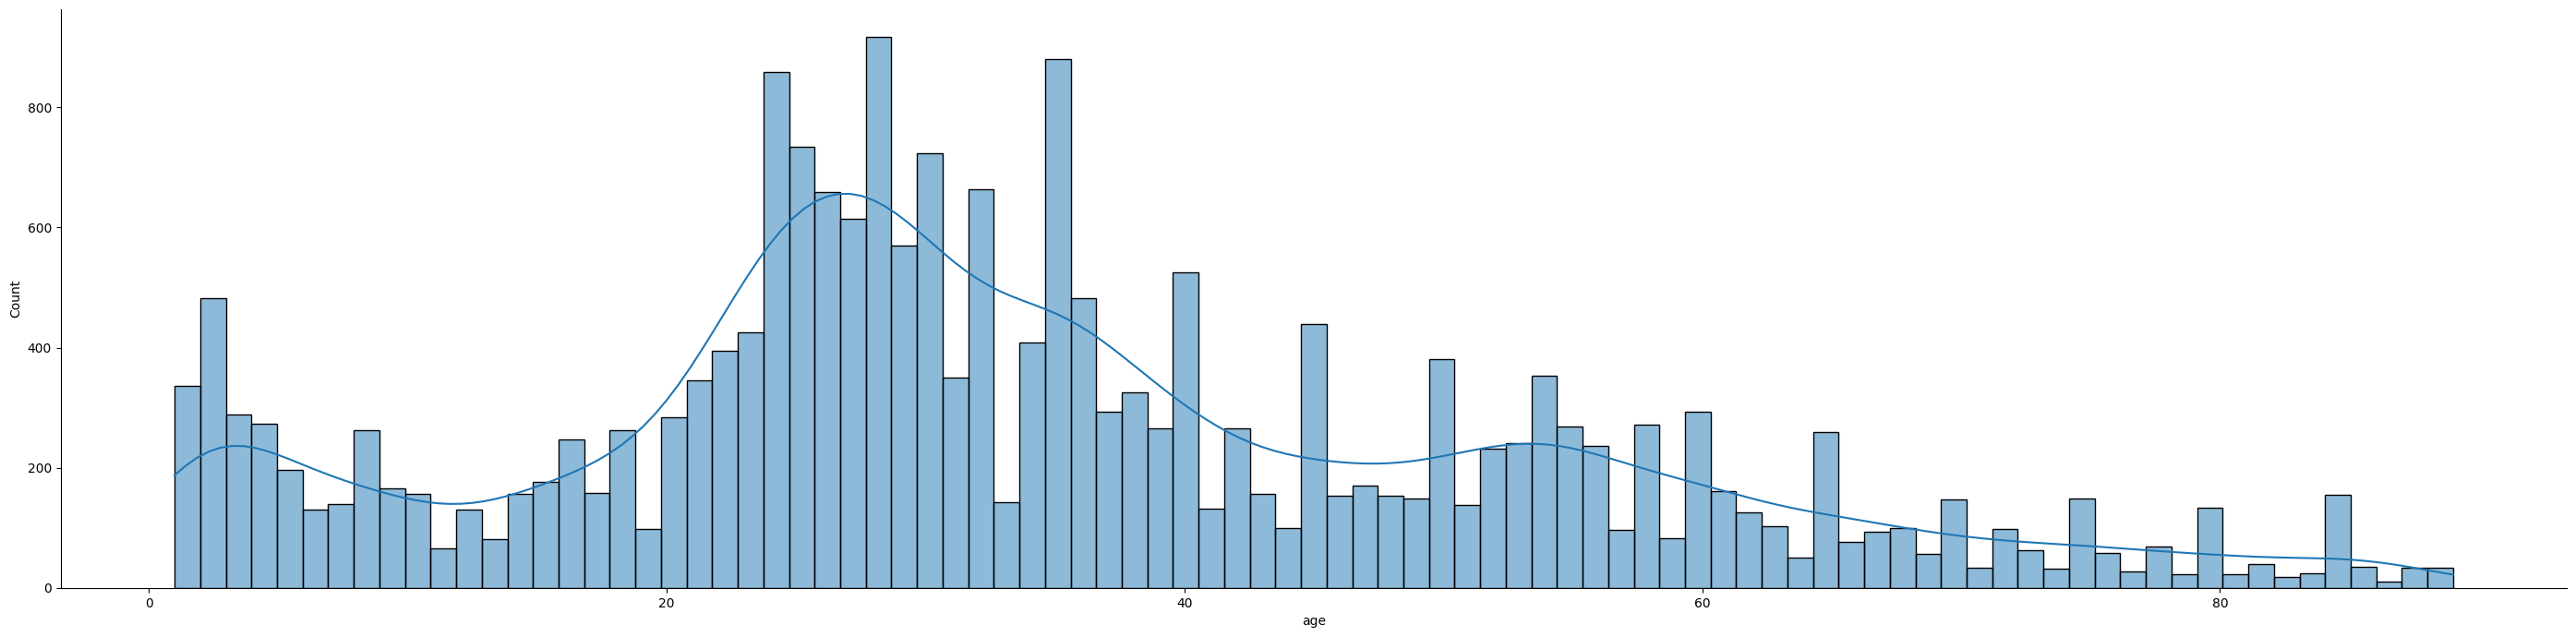

time: 711 ms (started: 2022-12-26 12:40:31 +00:00)


In [ ]:
ax = sns.displot(data=df2['age'], kde=True, height=7, aspect=4,  bins = 89)
ax.fig.set_dpi(100)

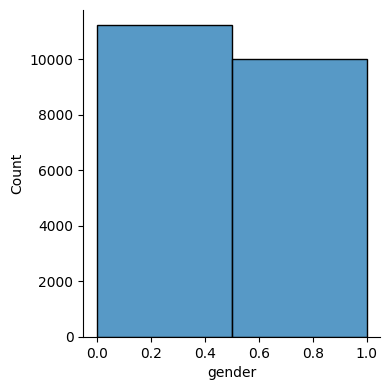

time: 246 ms (started: 2022-12-26 12:40:32 +00:00)


In [ ]:
ax = sns.displot(data=df2['gender'], height=4, aspect=1,  bins = 2)
ax.fig.set_dpi(100)

In [ ]:
df2.shape

(21215, 3)

time: 12.3 ms (started: 2022-12-26 12:40:32 +00:00)


In [ ]:
df2_copy = df2.copy()
df2_copy = df2_copy.drop(columns = ['image'])

time: 6.86 ms (started: 2022-12-26 12:40:32 +00:00)


In [ ]:
df2_copy.dtypes

age       float32
gender      int32
dtype: object

time: 5.49 ms (started: 2022-12-26 12:40:33 +00:00)


In [ ]:
len(df2_copy[df2_copy['gender'] == 1.0].index)

10003

time: 4.3 ms (started: 2022-12-26 12:40:33 +00:00)


In [ ]:
len(df2_copy[df2_copy['gender'] == 0].index)

11212

time: 9.89 ms (started: 2022-12-26 12:40:33 +00:00)


In [ ]:
df2_copy.head()

age  gender
0  30.0       1
2  28.0       1
3  35.0       1
4  34.0       1
6  38.0       0

time: 9.24 ms (started: 2022-12-26 12:40:33 +00:00)


In [ ]:
pie = df2_copy.groupby('gender')['gender'].count().reset_index(name='counts')
pie

gender  counts
0       0   11212
1       1   10003

time: 8.25 ms (started: 2022-12-26 12:40:33 +00:00)


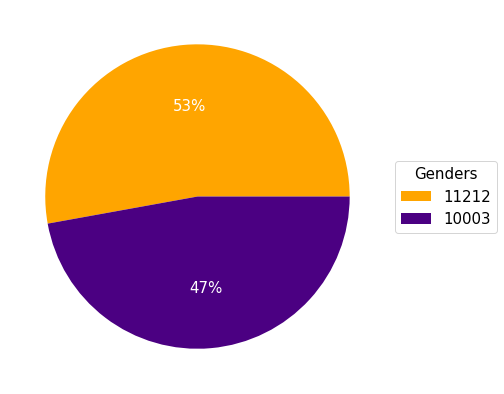

time: 76.7 ms (started: 2022-12-26 12:40:33 +00:00)


In [ ]:
#define Seaborn color palette to use
# colors = sns.color_palette('bright')[1:4]
labels = ['Male', 'Female']

# fig, ax = plt.subplots(figsize =(10, 7))
colors = ( "orange", "indigo")

#font size
mlb.rcParams['font.size'] = 15.0


# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
ax.pie(pie['counts'], 
       labels = labels, 
       colors = colors, 
       autopct='%.0f%%',
       textprops = dict(color ="white")      
      )

# Adding legend
ax.legend(pie['counts'],
          title ="Genders",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
#create pie chart
# plt.rcParams["figure.figsize"] = (15,10)
# plt.pie(pie['counts'], labels = labels, colors = colors, autopct='%.0f%%')
plt.show()



# 5.Extracting Features & Normalizing data

In [ ]:
# Будем исходить из разбиения возраста на 10 групп 
# и предсказания будем делать в соответсвии с этими группами

def age_group(age):
    if age >= 0 and age < 7:
        return 1
    elif age >= 7 and age < 12:
        return 2
    elif age >= 12 and age < 18:
        return 3
    elif age >= 18 and age < 25:
        return 4
    elif age >= 25 and age < 30:
        return 5
    elif age >= 30 and age < 40:
        return 6 
    elif age >= 40 and age < 50:
        return 7
    elif age >= 50 and age < 60:
        return 8
    elif age <= 90:
        return 9
    else:
        return 10

time: 1.75 ms (started: 2022-12-26 12:40:37 +00:00)


In [ ]:
df2

image   age  gender
0      [[[70], [63], [50], [57], [80], [91], [93], [1...  30.0       1
2      [[[29], [60], [21], [5], [17], [24], [36], [45...  28.0       1
3      [[[95], [93], [91], [90], [91], [92], [104], [...  35.0       1
4      [[[83], [82], [71], [63], [54], [52], [47], [3...  34.0       1
6      [[[252], [250], [251], [250], [233], [165], [9...  38.0       0
...                                                  ...   ...     ...
6047   [[[11], [19], [29], [39], [44], [50], [47], [5...  26.0       1
18105  [[[207], [207], [207], [207], [207], [208], [2...  26.0       1
4066   [[[74], [73], [72], [73], [73], [71], [70], [7...  26.0       0
20528  [[[8], [7], [6], [5], [5], [2], [7], [15], [74...  26.0       1
1811   [[[178], [95], [30], [6], [3], [1], [0], [2], ...  26.0       1

[21215 rows x 3 columns]

time: 6.62 s (started: 2022-12-26 12:40:37 +00:00)


In [ ]:
df2_size = df2.shape[0]
df2_size

21215

time: 5.32 ms (started: 2022-12-26 12:40:44 +00:00)


In [ ]:
# df2.head(25)

time: 442 µs (started: 2022-12-26 12:40:44 +00:00)


In [ ]:
index_list = list(df2.index.values) # convert index df2 to list for circle

time: 2.62 ms (started: 2022-12-26 12:40:44 +00:00)


100%|██████████| 21215/21215 [00:00<00:00, 23061.48it/s]


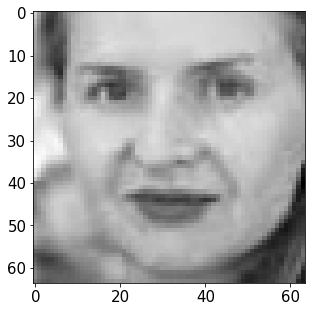

time: 1.35 s (started: 2022-12-26 12:40:44 +00:00)


In [ ]:
# age_labels, gender_labels, image_path = [], [], []
plt.rcParams["figure.figsize"] = (5,5)
target = np.zeros((size,2),dtype='float32')       # for age and gender
features = np.zeros((size,sample.shape[0],sample.shape[1],1),dtype = 'float32')
for i in tqdm(index_list): # use our converting indexes
    target[i,0] = age_group(df2['age'][i]) / 10      # age for 10 group
    target[i,1] = int(df2['gender'][i])              # gender
    features[i] = df2['image'][i]                    # our images
features = features / 255                            # normolizing
display(features[555])

# 6. TRAIN & TEST SPLIT

In [ ]:
target

array([[0.6, 1. ],
       [0. , 0. ],
       [0.5, 1. ],
       ...,
       [0.4, 1. ],
       [0.9, 0. ],
       [0.1, 1. ]], dtype=float32)

time: 3.54 ms (started: 2022-12-26 12:40:52 +00:00)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle = True, random_state=777)
print("Samples in Training:",x_train.shape[0])
print("Samples in Testing:",x_test.shape[0])

Samples in Training: 18966
Samples in Testing: 4742
time: 119 ms (started: 2022-12-26 12:40:53 +00:00)


In [ ]:
print("Shape of image:",sample.shape)

Shape of image: (64, 64, 1)
time: 864 µs (started: 2022-12-26 12:40:53 +00:00)


In [ ]:
y_test

array([[0.1, 0. ],
       [0.5, 0. ],
       [0.9, 1. ],
       ...,
       [0.9, 1. ],
       [0.5, 0. ],
       [0.6, 0. ]], dtype=float32)

time: 5.69 ms (started: 2022-12-26 12:40:53 +00:00)


# 7. Creating model

In [ ]:
# на входе на обучение подаем тензор рамером 64-64-1

input_size = (64,64,1)

inputs = Input(shape=input_size)
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)

x = Dropout(0.25)(pool2)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu')(age_model)
age_model = dropout(age_model)
output_1 = Dense(1, activation='relu', name='age_output')(age_model) 


dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu')(gender_model)
gender_model = dropout(gender_model)
output_2 = Dense(1, activation='sigmoid', name='gender_output')(gender_model) #(0 - 1)

time: 3.69 s (started: 2022-12-26 12:40:59 +00:00)


In [ ]:
from tensorflow import keras

model = Model(inputs=inputs, outputs=[output_1, output_2])
opt = keras.optimizers.Adam()
model.compile(loss=[tf.keras.metrics.mean_squared_error,'binary_crossentropy'], optimizer=opt, metrics=['accuracy'])
# model.compile(loss=['mse','binary_crossentropy'], optimizer=opt, metrics=['accuracy'])


time: 25.9 ms (started: 2022-12-26 12:41:03 +00:00)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 62, 62, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 60, 60, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 30, 30, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

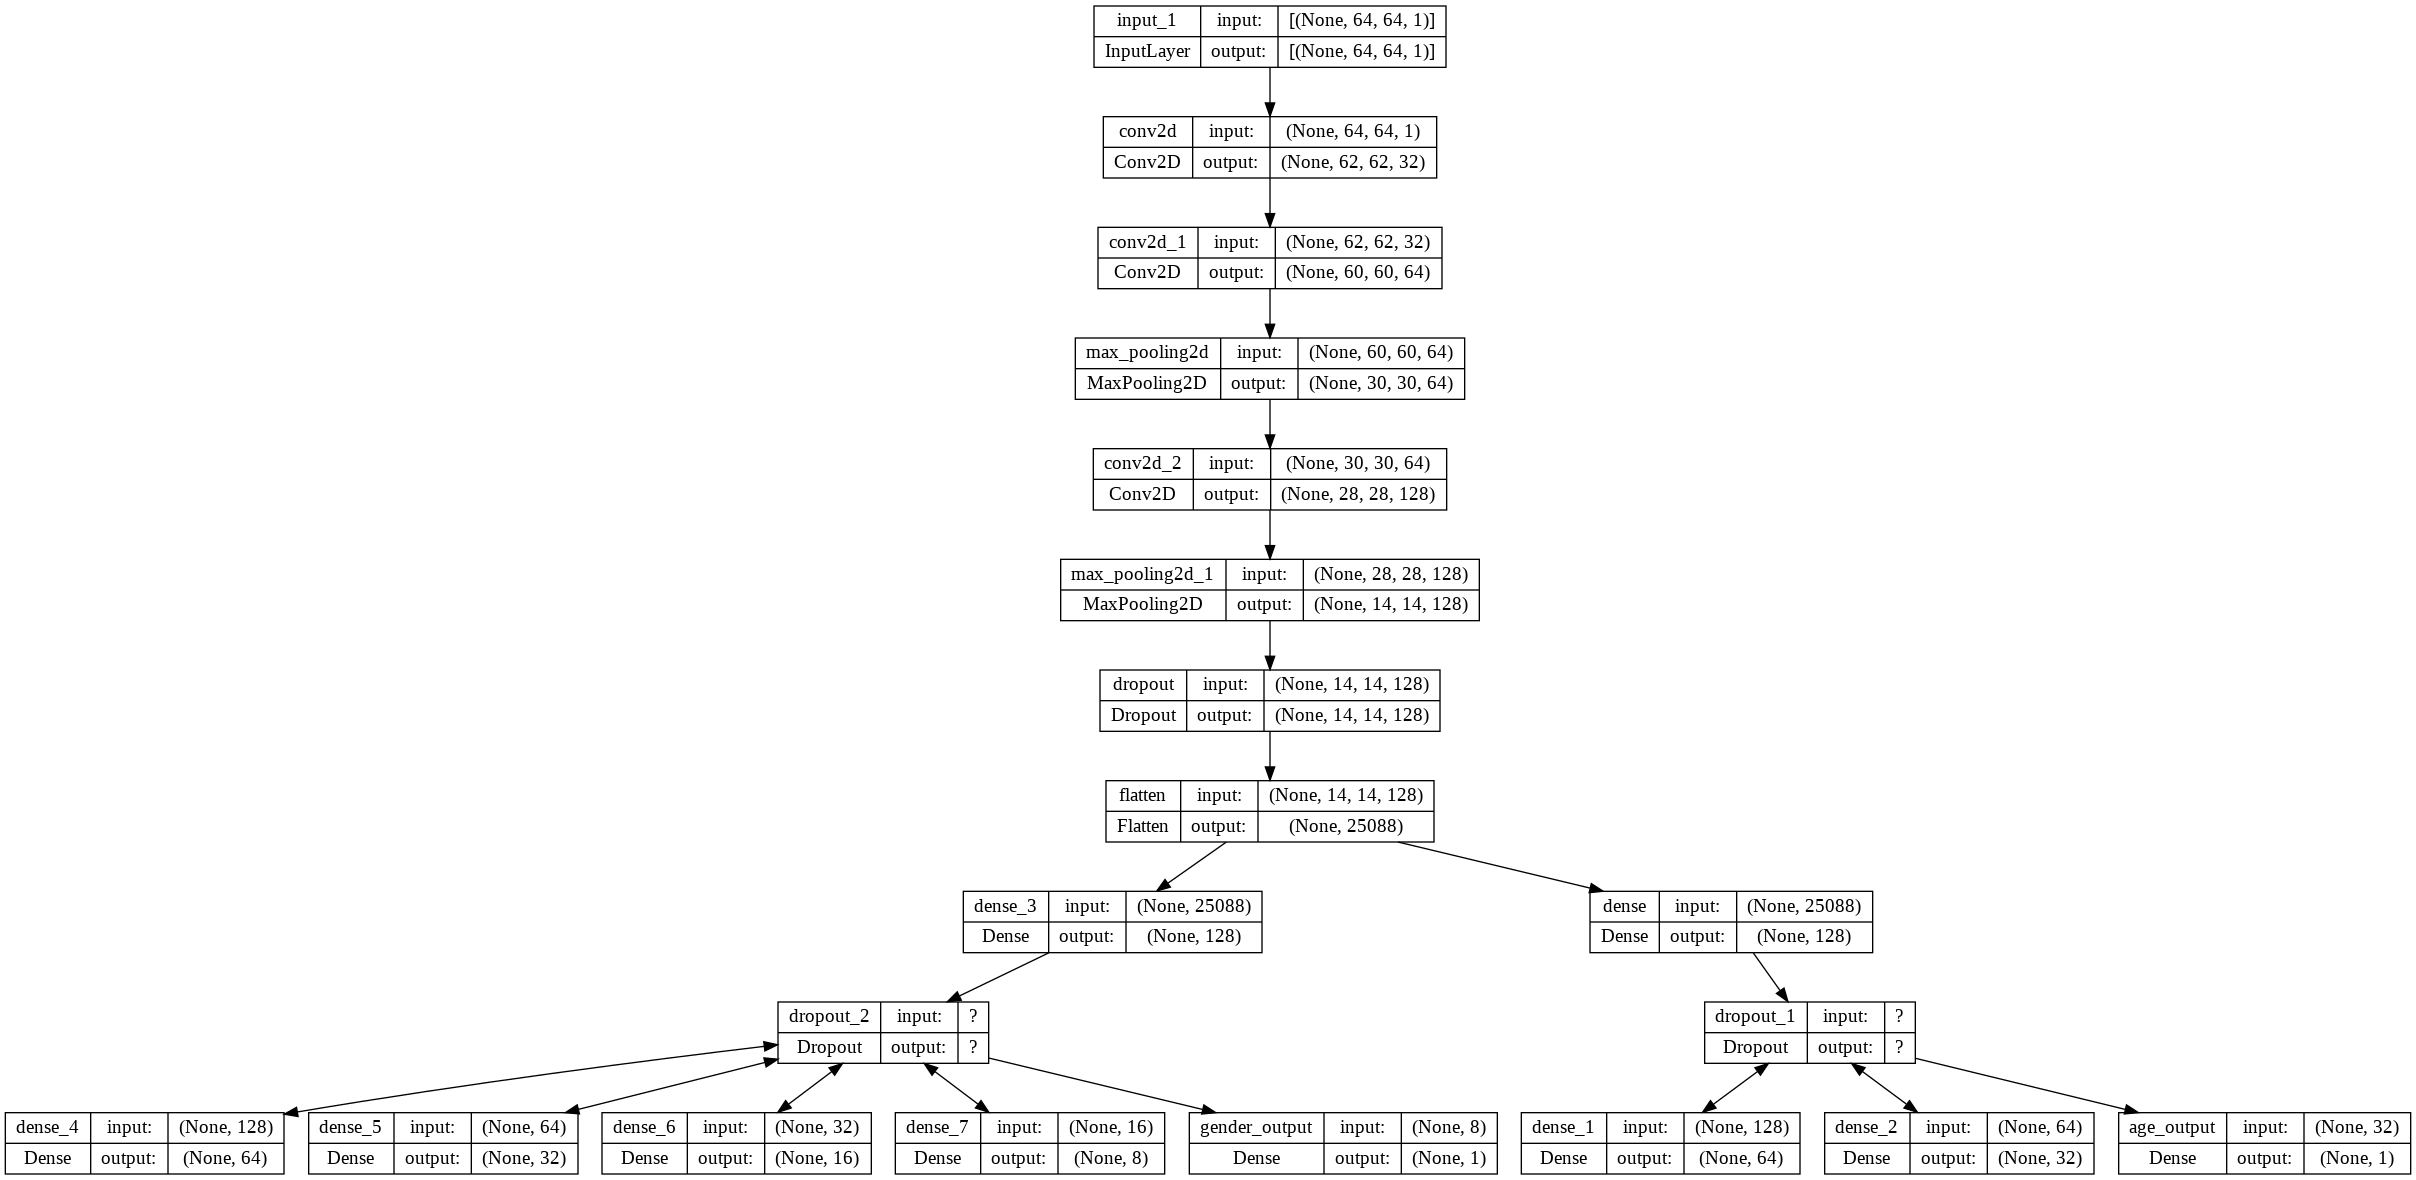

time: 870 ms (started: 2022-12-26 12:41:03 +00:00)


In [ ]:
from keras.utils.vis_utils import plot_model
plt.rcParams["figure.figsize"] = (20,20)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


# 8 .Training the model

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

time: 15.1 ms (started: 2022-12-26 12:41:04 +00:00)


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.

time: 773 µs (started: 2022-12-26 12:41:09 +00:00)


In [ ]:
with tf.device('GPU:0'):
      h = model.fit(
                x_train,
                [y_train[:,0],y_train[:,1]],
                validation_data=(x_test,[y_test[:,0],y_test[:,1]]),
                epochs = 100, 
                batch_size=128,
                shuffle = True,
                callbacks=[callback]
      )

Epoch 1/100
149/149 [==============================] - 18s 53ms/step - loss: 0.7695 - age_output_loss: 0.0892 - gender_output_loss: 0.6803 - age_output_accuracy: 0.1068 - gender_output_accuracy: 0.6066 - val_loss: 0.6675 - val_age_output_loss: 0.0337 - val_gender_output_loss: 0.6339 - val_age_output_accuracy: 0.0985 - val_gender_output_accuracy: 0.7457
Epoch 2/100
149/149 [==============================] - 7s 50ms/step - loss: 0.6098 - age_output_loss: 0.0492 - gender_output_loss: 0.5606 - age_output_accuracy: 0.1068 - gender_output_accuracy: 0.7769 - val_loss: 0.4573 - val_age_output_loss: 0.0307 - val_gender_output_loss: 0.4266 - val_age_output_accuracy: 0.0985 - val_gender_output_accuracy: 0.8636
Epoch 3/100
149/149 [==============================] - 7s 50ms/step - loss: 0.5057 - age_output_loss: 0.0415 - gender_output_loss: 0.4641 - age_output_accuracy: 0.1068 - gender_output_accuracy: 0.8280 - val_loss: 0.3635 - val_age_output_loss: 0.0279 - val_gender_output_loss: 0.3356 - val_ag

In [ ]:
model.save('data.h5')

# 9. Visualizing loss

In [ ]:
history = h

time: 549 µs (started: 2022-12-26 12:45:27 +00:00)


In [ ]:
plt.rcParams["figure.figsize"] = (15,10)

time: 731 µs (started: 2022-12-26 12:45:28 +00:00)


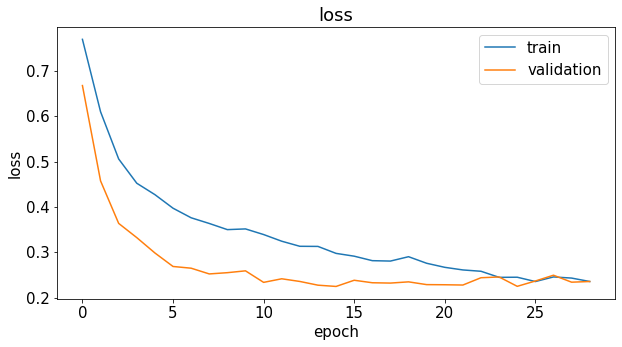

time: 14.5 s (started: 2022-12-26 12:45:28 +00:00)


In [ ]:
# COMMON LOS 
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')


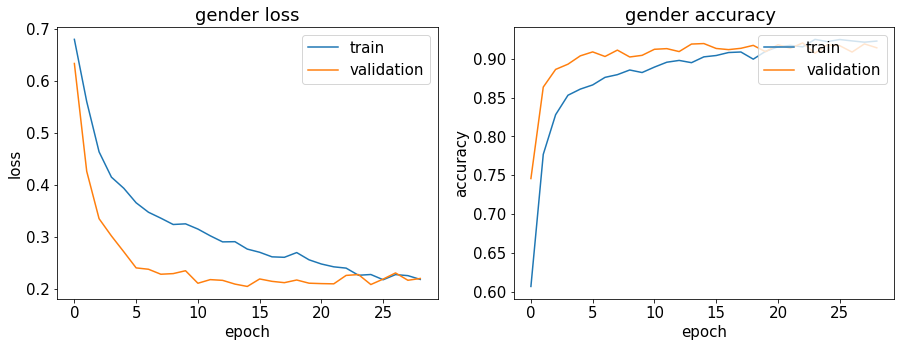

time: 661 ms (started: 2022-12-26 12:45:42 +00:00)


In [ ]:
# GENDER LOS and ACCURACY
plt.rcParams["figure.figsize"] = (15,5)

plt.subplot(1,2,1)

plt.plot(history.history['gender_output_loss'])
plt.plot(history.history['val_gender_output_loss'])
plt.title('gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')


plt.subplot(1,2,2)

plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('gender accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

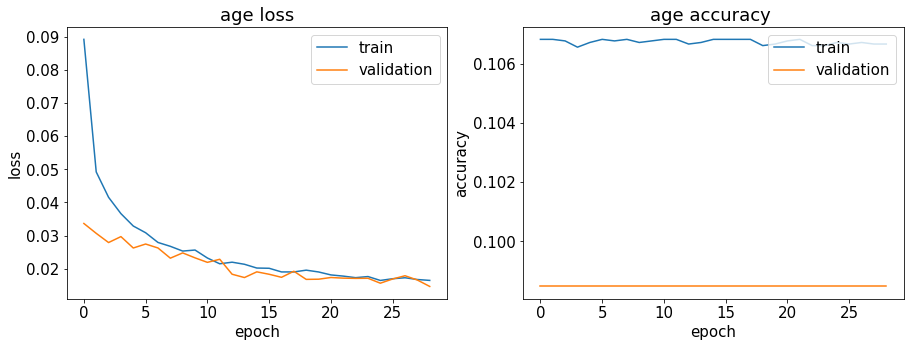

time: 942 ms (started: 2022-12-26 12:45:43 +00:00)


In [ ]:
plt.rcParams["figure.figsize"] = (15,5)

plt.subplot(1,2,1)

plt.plot(history.history['age_output_loss'])
plt.plot(history.history['val_age_output_loss'])
plt.title('age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.subplot(1,2,2)

plt.plot(history.history['age_output_accuracy'])
plt.plot(history.history['val_age_output_accuracy'])
plt.title('age accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

In [ ]:
# evaluate the model
with tf.device('GPU:0'):
    train_acc = model.evaluate(x_train, [y_train[:,0],y_train[:,1]], verbose=1)
    test_acc = model.evaluate(x_test,[y_test[:,0],y_test[:,1]], verbose=1)
# print('train age_output_accuracy' + train_acc[4])

149/149 [==============================] - 1s 7ms/step - loss: 0.2354 - age_output_loss: 0.0146 - gender_output_loss: 0.2207 - age_output_accuracy: 0.0985 - gender_output_accuracy: 0.9142
time: 6.81 s (started: 2022-12-26 12:45:44 +00:00)


In [ ]:
# print(train_acc)
# print(test_acc)
print('-------------')
print('train age_output_accuracy ---- ' + str(train_acc[3]))
print('test age_output_accuracy  ---- ' + str(test_acc[3]))
print('-------------')
print('train gender_output_accuracy ---- ' + str(train_acc[4]))
print('test gender_output_accuracy  ---- ' + str(test_acc[4]))
print('-------------')

-------------
train age_output_accuracy ---- 0.10682273656129837
test age_output_accuracy  ---- 0.09848165512084961
-------------
train gender_output_accuracy ---- 0.9654645323753357
test gender_output_accuracy  ---- 0.9141712188720703
-------------
time: 1.67 ms (started: 2022-12-26 12:45:51 +00:00)


# 10. Predicting test image

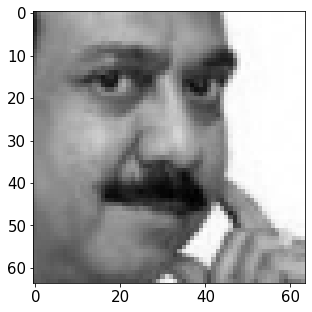

Actual Gender: Male Age: 45
1/1 [==============================] - 0s 197ms/step
Values for age: [[0.6634396]] Values for gender: [[0.00098797]] 
Predicted Gender: Male Predicted Age: 30-39


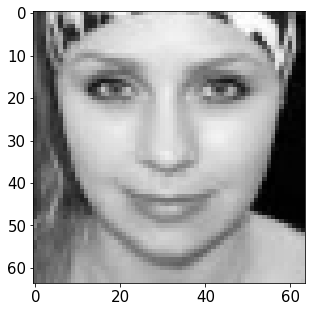

Actual Gender: Female Age: 35
1/1 [==============================] - 0s 17ms/step
Values for age: [[0.5410398]] Values for gender: [[0.9999989]] 
Predicted Gender: Female Predicted Age: 25-29


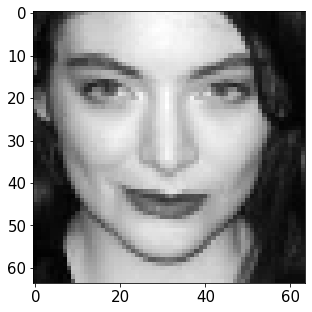

Actual Gender: Female Age: 17
1/1 [==============================] - 0s 15ms/step
Values for age: [[0.43375742]] Values for gender: [[0.9980894]] 
Predicted Gender: Female Predicted Age: 18-24


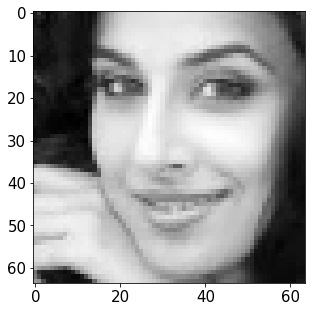

Actual Gender: Female Age: 28
1/1 [==============================] - 0s 26ms/step
Values for age: [[0.49262983]] Values for gender: [[1.]] 
Predicted Gender: Female Predicted Age: 18-24


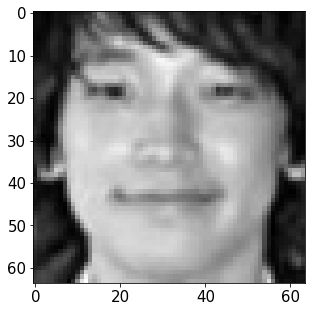

Actual Gender: Male Age: 26
1/1 [==============================] - 0s 16ms/step
Values for age: [[0.4874475]] Values for gender: [[0.319968]] 
Predicted Gender: Male Predicted Age: 18-24


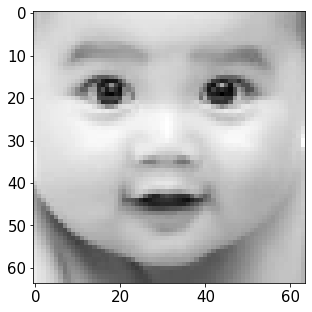

Actual Gender: Male Age: 1
1/1 [==============================] - 0s 18ms/step
Values for age: [[0.18732697]] Values for gender: [[0.27870595]] 
Predicted Gender: Male Predicted Age: 0-6


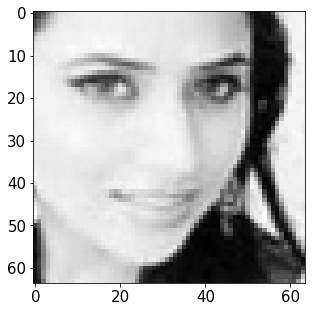

Actual Gender: Female Age: 23
1/1 [==============================] - 0s 18ms/step
Values for age: [[0.4709906]] Values for gender: [[0.9999987]] 
Predicted Gender: Female Predicted Age: 18-24


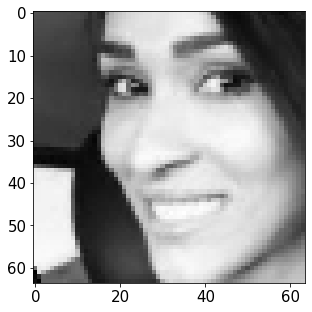

Actual Gender: Female Age: 29
1/1 [==============================] - 0s 15ms/step
Values for age: [[0.60366845]] Values for gender: [[0.99999106]] 
Predicted Gender: Female Predicted Age: 30-39


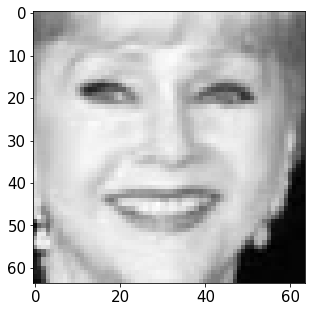

Actual Gender: Female Age: 62
1/1 [==============================] - 0s 15ms/step
Values for age: [[0.63113034]] Values for gender: [[0.9999994]] 
Predicted Gender: Female Predicted Age: 30-39
time: 1.82 s (started: 2022-12-26 12:46:00 +00:00)


In [ ]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()
    
# def age_group(age):
#     if age >=0 and age < 18:
#         return 1
#     elif age < 30:
#         return 2
#     elif age < 80:
#         return 3
#     else:
#         return 4


def age_group(age):
    if age >= 0 and age < 7:
        return 1
    elif age >= 7 and age < 12:
        return 2
    elif age >= 12 and age < 18:
        return 3
    elif age >= 18 and age < 25:
        return 4
    elif age >= 25 and age < 30:
        return 5
    elif age >= 30 and age < 40:
        return 6 
    elif age >= 40 and age < 50:
        return 7
    elif age >= 50 and age < 60:
        return 8
    elif age < 90:
        return 9
    else:
        return 10

def get_age(distr):
    distr = distr * 10
    if distr >= 0 and distr < 2 :return "0-6"
    if distr >= 2 and distr < 3 :return "7-11"
    if distr >= 3 and distr < 4 :return "12-17"
    if distr >= 4 and distr < 5 :return "18-24"
    if distr >= 5 and distr < 6 :return "25-29"
    if distr >= 6 and distr < 7 :return "30-39"
    if distr >= 7 and distr < 8 :return "40-49"
    if distr >= 8 and distr < 9 :return "50-59"
    if distr >= 9 and distr <10 :return "60-89"  
    if distr >= 10 :return "90 +"
    return "Unknown"
# def get_age(distr):
#     distr = distr*4
#     if distr >= 0.65 and distr <= 1.4:return "0-18"
#     if distr >= 1.65 and distr <= 2.4:return "19-30"
#     if distr >= 2.65 and distr <= 3.4:return "31-80"
#     if distr >= 3.65 and distr <= 4.4:return "80 +"
#     return "Unknown"
    
def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

def get_result(sample):
    sample = sample/255
    val = model.predict(np.array([ sample ]) )    
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("Values for age:",val[0],"Values for gender:",val[1], "\nPredicted Gender:",gender,"Predicted Age:",age )
    
    
indexes = [500,59,80,2,4546,7,9,256,696]
# indexes = [600,58,87,8,456,696,10,258,47]
for idx in indexes:
    sample = image_path[idx]
#     print(sample)
    display(sample)
    print("Actual Gender:",get_gender(gender_labels[idx]),"Age:",age_labels[idx])
    res = get_result(sample)

# ------Test on foto not in dataset------------

In [ ]:
# test_file = "/kaggle/input/fototest2/26622.jpg"

In [ ]:
def display2(img):
    plt.imshow(img)
#     plt.set_cmap('gray')
    plt.show()

In [ ]:
# import PIL # We will import the packages at "use-time (just for this kernel)

# PIL.Image.open(test_file)

In [ ]:
# image = cv2.cvtColor(cv2.imread(test_file), cv2.COLOR_BGR2RGB) # исходник 

In [ ]:
# image = cv2.imread(test_file,0)
# display2(image)

In [ ]:
ls ../input/

In [ ]:
! pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 7.1 MB/s 
time: 3.21 s (started: 2022-12-26 12:52:39 +00:00)


In [ ]:
import cv2
from mtcnn import MTCNN
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (70,10)

time: 8.17 ms (started: 2022-12-26 12:52:45 +00:00)


In [ ]:
# detector = MTCNN() # создание детектора
# result = detector.detect_faces(image)  # обнаружение лиц на изображении
# for i in range(len(result)): 
#     bounding_box = result[i]['box']  #  ограничивающие рамки
#     cv2.rectangle(image, 
#                   (bounding_box[0], bounding_box[1]),
#                   (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
#                   (0,155,255), 6) #  ограничение области на изображении
#     plt.imshow(image) # показать полученное изображение

In [ ]:
pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.2 MB/s 
time: 4.44 s (started: 2022-12-26 12:53:05 +00:00)


In [ ]:
img_path = "f.jpg"

time: 660 µs (started: 2022-12-26 13:08:52 +00:00)


In [ ]:
! ls

f.jpg  kaggle.json  model_plot.png  sample_data  utkface-new  utkface-new.zip
time: 232 ms (started: 2022-12-26 13:06:33 +00:00)


In [293]:
def tensor_box(img_path):
        from facenet_pytorch import MTCNN
        from PIL import Image
        import numpy as np

        # img = Image.open(img_path)
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        # frame = cv2.cvtColor(img_path, cv2.COLOR_BGR2RGB)
        # frame = Image.fromarray(frame) 

        mtcnn = MTCNN(margin=20, keep_all=True, post_process=False) # detector faces

        FACES = mtcnn(image) 
        return FACES
    
FACES = tensor_box(img_path)
    

time: 11.9 s (started: 2022-12-26 16:29:26 +00:00)


In [ ]:
FACES.shape

torch.Size([5, 3, 160, 160])

time: 3.83 ms (started: 2022-12-26 13:09:11 +00:00)


In [404]:
from mtcnn import MTCNN
import matplotlib.pyplot as plt

def show_image_with_box(path):
    
    from mtcnn import MTCNN
    import matplotlib.pyplot as plt
    
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    detector = MTCNN() # создание детектора
    # with tf.device('GPU:0'):
    result = detector.detect_faces(image)  # обнаружение лиц на изображении
    for i in range(len(result)): 
        bounding_box = result[i]['box']  #  ограничивающие рамки
        cv2.rectangle(image, 
                      (bounding_box[0], bounding_box[1]),
                      (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
                      (0,155,255), 8) #  ограничение области на изображении
        # cv2.putText(img, "Hello world!", (185,170), cv2.FONT_HERSHEY_SIMPLEX, 1, color_yellow, 2)              
        plt.imshow(image) # показать полученное изображение

time: 2.11 ms (started: 2022-12-26 18:02:07 +00:00)


2/2 [==============================] - 0s 6ms/step


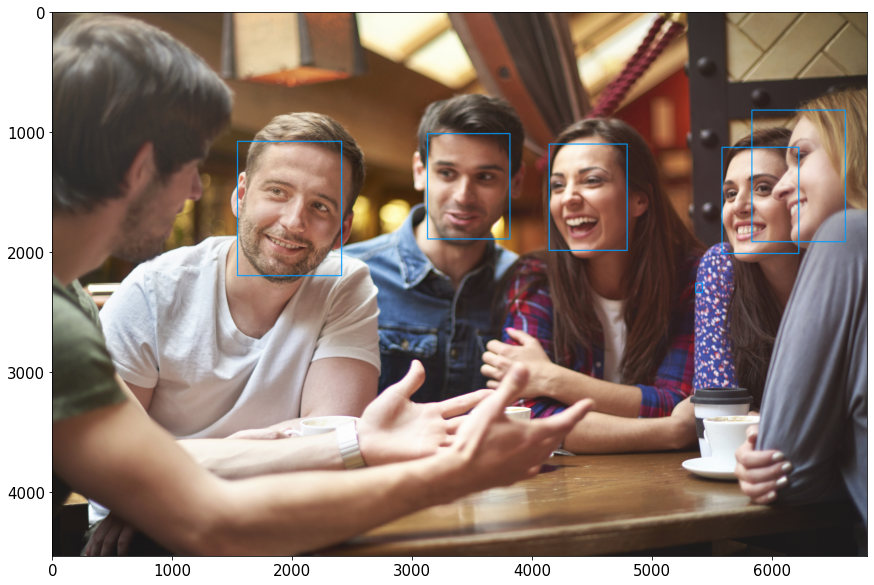

time: 31.1 s (started: 2022-12-26 18:02:12 +00:00)


In [405]:
plt.rcParams["figure.figsize"] = (70,10)

show_image_with_box(img_path)


In [ ]:
def image_line(FACES):
    plt.rcParams["figure.figsize"] = (60,10)
    fig, axes = plt.subplots(1, len(FACES))
    for face, ax in zip(FACES, axes):
        ax.imshow(face.permute(1, 2, 0).int().numpy())
        ax.axis('on')
    fig.show()

time: 1.31 ms (started: 2022-12-26 13:11:24 +00:00)


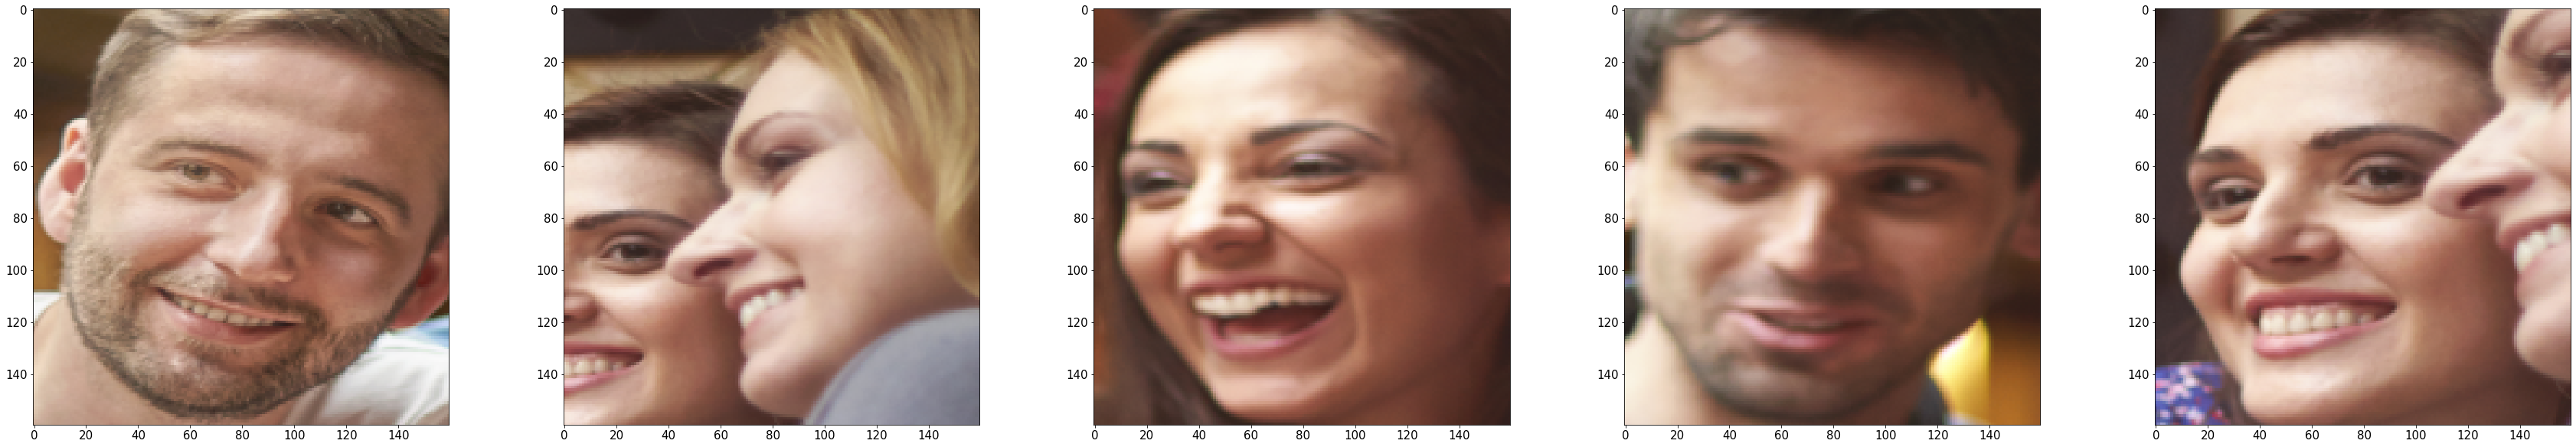

time: 979 ms (started: 2022-12-26 13:11:26 +00:00)


In [ ]:
image_line(FACES)

In [ ]:
# len(image_to_model)

crop_image_mass(FACES)

In [ ]:
def crop_image_show(faces):
        plt.figure(figsize=(10,10))
        x = faces.shape[0] // 2
        y = faces.shape[0] // 2 + 1
        # print(x,y)
        index = 0
        while index != faces.shape[0]:
            plt.subplot(x,y, index+1)
            img = faces[index].permute(1,2,0).int().numpy()
        #     img = np.array(df['image'][index])
            plt.imshow(img)
            index += 1
            plt.axis('off')

time: 1.6 ms (started: 2022-12-26 13:11:33 +00:00)


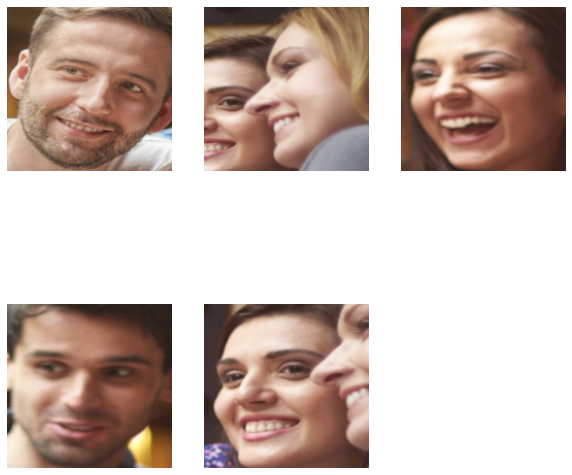

time: 269 ms (started: 2022-12-26 13:11:36 +00:00)


In [ ]:
crop_image_show(FACES)

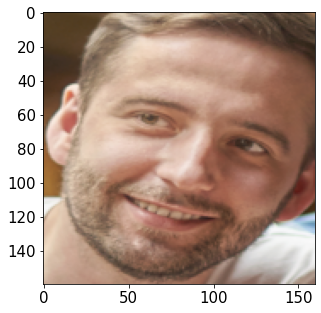

time: 186 ms (started: 2022-12-26 17:06:46 +00:00)


In [347]:
plt.rcParams["figure.figsize"] = (5,5)
img = FACES[0].permute(1,2,0).int().numpy()
plt.imshow(img)

# ---------------SAVE CROP IMAGE FOR TESTING IN MODEL-----------------

In [340]:
# save crop image to mass

def crop_image_mass(faces):
        index = 0
        image_mass = []
        while index != faces.shape[0]:
            img = faces[index].permute(1,2,0).int().numpy()
            image_mass.append(img)
            index += 1
            print('Img save')
        return image_mass   


time: 1.17 ms (started: 2022-12-26 17:00:49 +00:00)


In [341]:
image_to_model = crop_image_mass(FACES)

Img save
Img save
Img save
Img save
Img save
time: 6.05 ms (started: 2022-12-26 17:00:53 +00:00)


In [381]:
# save crop image to files
path_temp_crop = 'temp_image/' # create folder hends

import cv2

def crop_image_drive(faces):
        index = 0
        image_mass = []
        for index in range(faces.shape[0]):
            img = faces[index].permute(1,2,0).int().numpy()
            # image_mass.append(img)
            cv2.imwrite(path_temp_crop + 'image_crop_' + str(index)+ '.jpg', img)
            print('Img save local')
        # return image_mass   


time: 1.68 ms (started: 2022-12-26 17:28:20 +00:00)


In [ ]:
def crop_image_drive(faces):
        index = 0
        image_mass = []
        for index in range(faces.shape[0]):
            img = faces[index].permute(1,2,0).int().numpy()
            # image_mass.append(img)
            cv2.imwrite(path_temp_crop + 'image_crop_' + str(index)+ '.jpg', img)
            print('Img save local')
        # return image_mass

In [384]:
crop_image_drive(FACES)

Img save local
Img save local
Img save local
Img save local
Img save local
time: 13 ms (started: 2022-12-26 17:29:36 +00:00)


In [389]:
! ls -a ./temp_image

.   image_crop_0.jpg  image_crop_2.jpg	image_crop_4.jpg
..  image_crop_1.jpg  image_crop_3.jpg
time: 208 ms (started: 2022-12-26 17:32:25 +00:00)


In [379]:
! rm -rf ./temp_image/*

time: 210 ms (started: 2022-12-26 17:26:57 +00:00)


In [388]:
! rm -rf ./temp_image/.ipynb_checkpoints

time: 211 ms (started: 2022-12-26 17:32:18 +00:00)


In [390]:
files_crop = os.listdir(path_temp_crop)
size = len(files_crop)
print("Total samples:",size)
print(files[0])

Total samples: 5
image_crop_2.jpg
time: 3.34 ms (started: 2022-12-26 17:32:34 +00:00)


In [391]:
image_path_crop = []
for file in tqdm(files_crop):
    imgcrop = cv2.imread(path_temp_crop + file,0)
    # imgcrop = cv2.imread('/content/temp_image/image_crop_0.jpg',0)
    imgcrop = cv2.resize(imgcrop,dsize=(64,64))
    imgcrop = imgcrop.reshape((imgcrop.shape[0],imgcrop.shape[1],1))
    image_path_crop.append(imgcrop)

100%|██████████| 5/5 [00:00<00:00, 1636.61it/s]

time: 16.8 ms (started: 2022-12-26 17:32:49 +00:00)


In [392]:
image_path_crop[0].shape

(64, 64, 1)

time: 3.36 ms (started: 2022-12-26 17:33:09 +00:00)


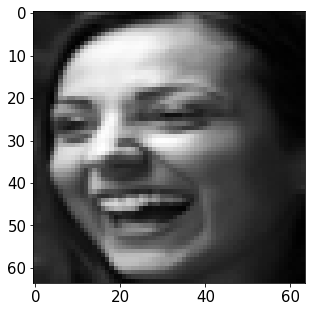

time: 147 ms (started: 2022-12-26 17:33:24 +00:00)


In [393]:
plt.rcParams["figure.figsize"] = (5,5)

plt.imshow(image_path_crop[0][:,:,0], cmap='gray')

# ------------ TESTING MODEL ------------------

In [503]:
def get_result_test(sample):
    label = []
    sample = sample/255
    val = model.predict(np.array([ sample ]) )    
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("Values for age:",val[0],"Values for gender:",val[1], "\nPredicted Gender:",gender,"Predicted Age:",age )
    
    label.append([gender, age])
    # print(label)

    return label 

time: 1.53 ms (started: 2022-12-26 20:04:01 +00:00)


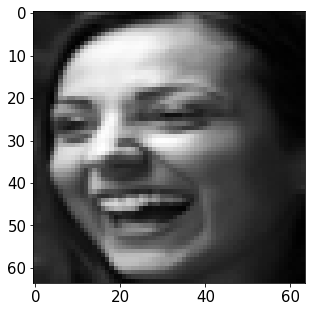

1/1 [==============================] - 0s 16ms/step
Values for age: [[0.6048639]] Values for gender: [[0.8789881]] 
Predicted Gender: Female Predicted Age: 30-39


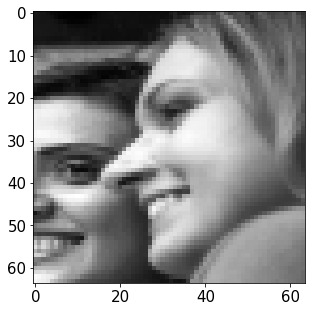

1/1 [==============================] - 0s 16ms/step
Values for age: [[0.56132597]] Values for gender: [[0.3184384]] 
Predicted Gender: Male Predicted Age: 25-29


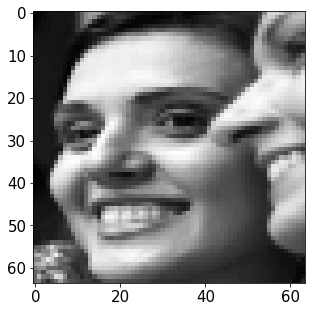

1/1 [==============================] - 0s 22ms/step
Values for age: [[0.59529793]] Values for gender: [[0.6276413]] 
Predicted Gender: Female Predicted Age: 25-29


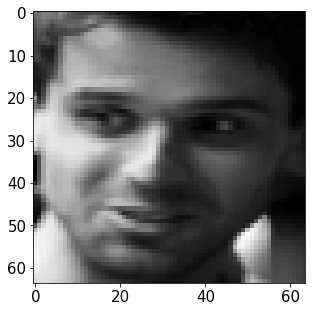

1/1 [==============================] - 0s 63ms/step
Values for age: [[0.41394487]] Values for gender: [[0.09515482]] 
Predicted Gender: Male Predicted Age: 18-24


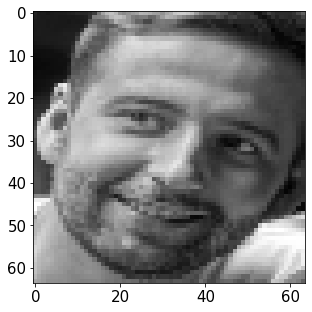

1/1 [==============================] - 0s 57ms/step
Values for age: [[0.6885866]] Values for gender: [[0.08681504]] 
Predicted Gender: Male Predicted Age: 30-39
time: 1.14 s (started: 2022-12-26 20:04:04 +00:00)


In [504]:
plt.rcParams["figure.figsize"] = (5,5)
labels = []
for idx in range(size):
    sample = image_path_crop[idx]
    display(sample)
    res = get_result_test(sample)
    labels.append(res)

In [ ]:
img_path = "f.jpg"

In [555]:
from mtcnn import MTCNN
import matplotlib.pyplot as plt

image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
detector = MTCNN() # создание детектора
result = detector.detect_faces(image)  # обнаружение лиц на изображении

2/2 [==============================] - 0s 7ms/step
time: 8.9 s (started: 2022-12-26 20:42:33 +00:00)


In [530]:
result

[{'box': [3130, 1013, 687, 878],
  'confidence': 1.0,
  'keypoints': {'left_eye': (3300, 1349),
   'right_eye': (3627, 1383),
   'nose': (3419, 1581),
   'mouth_left': (3291, 1680),
   'mouth_right': (3577, 1712)}},
 {'box': [1546, 1077, 868, 1120],
  'confidence': 0.9999901056289673,
  'keypoints': {'left_eye': (1873, 1499),
   'right_eye': (2251, 1619),
   'nose': (2023, 1774),
   'mouth_left': (1780, 1880),
   'mouth_right': (2127, 1988)}},
 {'box': [4144, 1100, 650, 886],
  'confidence': 0.9997251629829407,
  'keypoints': {'left_eye': (4217, 1455),
   'right_eye': (4495, 1411),
   'nose': (4284, 1575),
   'mouth_left': (4273, 1779),
   'mouth_right': (4558, 1741)}},
 {'box': [5585, 1127, 640, 885],
  'confidence': 0.9994383454322815,
  'keypoints': {'left_eye': (5687, 1521),
   'right_eye': (5945, 1490),
   'nose': (5721, 1626),
   'mouth_left': (5691, 1829),
   'mouth_right': (5950, 1790)}},
 {'box': [5834, 817, 779, 1097],
  'confidence': 0.9883963465690613,
  'keypoints': {'left

time: 9.03 ms (started: 2022-12-26 20:22:05 +00:00)


In [511]:
labels

[[['Female', '30-39']],
 [['Male', '25-29']],
 [['Female', '25-29']],
 [['Male', '18-24']],
 [['Male', '30-39']]]

time: 4.71 ms (started: 2022-12-26 20:07:54 +00:00)


In [521]:
labels[0][0][0]

'Female'

time: 12 ms (started: 2022-12-26 20:11:24 +00:00)


In [543]:
plt.rcParams["figure.figsize"] = (50,10)

time: 641 µs (started: 2022-12-26 20:32:08 +00:00)


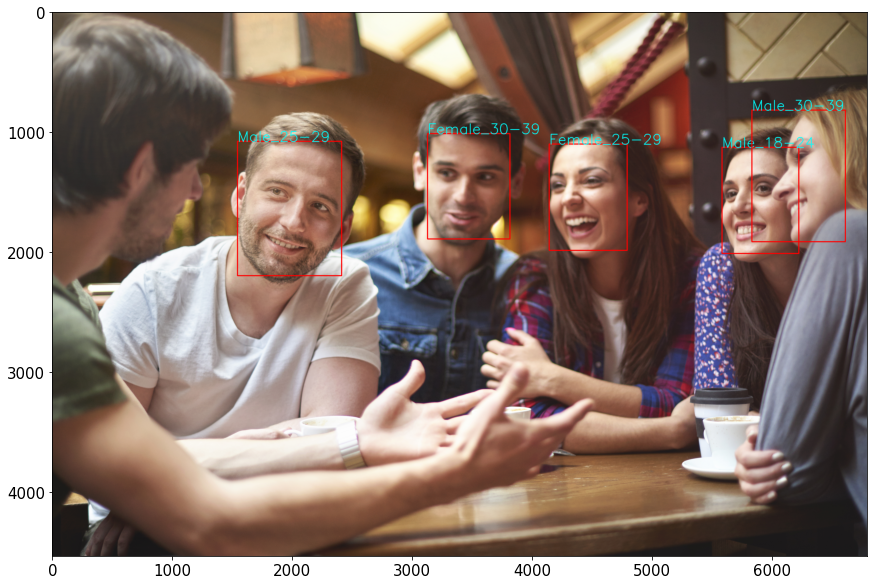

time: 20.2 s (started: 2022-12-26 20:42:52 +00:00)


In [556]:
color_red = (255,0,0)
color_yellow = (0,255,255)
color_purple = (255,0,255)

count = 0

# print(len(FACES))

for face in result: 
                 
        # Getting the co-ordinates of the bounding box.
     
        if float(face['confidence'])>0.9:
            
          x, y, w, h = face['box']
          # Getting Region Of Image(ROI)
          # f_img = frame[y:y+h, x:x+w]
          # # Resizing the face in the shape of (self.width, self.height)
          # f_img = cv2.resize(f_img, (self.width, self.height))
          # # Calling the helper function to get the label.
          label = labels[count][0][0] + '_' + labels[count][0][1]
          count+=1
       
          # Drawing rectangle and putting text on the bounding box of each fce
          cv2.rectangle(image, (x,y), (x+w, y+h), color_red, 8, 10)
          cv2.putText(image, label, (x, y+2), cv2.FONT_HERSHEY_SIMPLEX, 4, color_yellow, 6)
          plt.imshow(image) # показать полученное изображение
        

In [419]:
show_image_with_box_and_text(img_path)

2/2 [==============================] - 0s 6ms/step


TypeError: ignored

time: 8.34 s (started: 2022-12-26 18:28:36 +00:00)


2/2 [==============================] - 0s 7ms/step


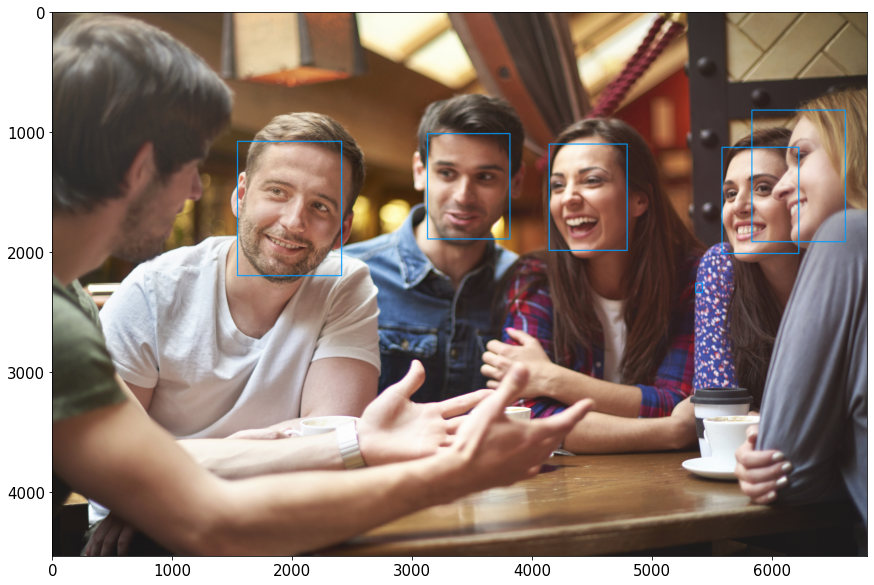

time: 33.1 s (started: 2022-12-26 20:54:43 +00:00)


In [557]:
plt.rcParams["figure.figsize"] = (70,10)

show_image_with_box(img_path)

# --Черновик


In [ ]:
# files = df.iloc[0:20]
# plt.figure(figsize=(15,15))
# for index, file, age, gender in files.itertuples():
#     plt.subplot(5,5, index+1)
#     plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
#     img = np.array(df['image'][index])
#     plt.imshow(img)
#     plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
#     plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
#     plt.axis('off')

In [ ]:
# def predict_age_and_gender(index):    
#     print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

#     pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
#     pred_gender = gender_dict[round(pred[0][0][0])] 
#     pred_age = round(pred[1][0][0])

#     print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
#     plt.imshow(x_train[index].reshape(128,128), cmap='gray')

In [ ]:
# predict_age_and_gender(881)

In [ ]:
# predict_age_and_gender(888)

In [ ]:
# predict_age_and_gender(888)

In [ ]:
# predict_age_and_gender(555)

In [ ]:
# predict_age_and_gender(455)

In [ ]:
# index=50
# print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

# pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
# pred_gender = gender_dict[round(pred[0][0][0])] 
# pred_age = round(pred[1][0][0])

# print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
# plt.imshow(x_train[index].reshape(128,128), cmap='gray')

According to the loss, the model is overfitting. I should have add some more regularization in the model to prevent overfitting but it is taking a lot of time. With 5k images, it takes 2.5 hours to fit on the train set. I stopped here but you can try adding regularization techniques to prevent overfitting.

In [ ]:
# index=20
# print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

# pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
# pred_gender = gender_dict[round(pred[0][0][0])] 
# pred_age = round(pred[1][0][0])

# print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
# plt.imshow(x_train[index].reshape(128,128), cmap='gray')

In [ ]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))